## Data Sources and Import Statements

Data have been downloaded from the Earth System Grid Federation at https://esgf-node.ipsl.upmc.fr/projects/esgf-ipsl/.

Each file has been concatenated to contain ssp119 and ssp126 scenarios and r1-5 ensemble members from 2015 to 2100. Each has also been regridded to 2.5° resolution.

In [3]:
# IMPORT STATEMENTS

# General useful libraries
import math
import os
import re
# Loading in data (netcdf files)
import h5py
# Handling data
import pandas as pd
import numpy as np
import netCDF4 as nc
# Installing xarray and its dependencies
import xarray as xr
import scipy 
import dask
import bottleneck
# Plotting figures
import matplotlib.pyplot as plt # Main plotting package
from matplotlib.ticker import MultipleLocator # Supporting plotting package 
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker
# Machine Learning package
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() 
print(tf.__version__)
# Interpreting neural networks 
import shap

2026-01-31 20:36:06.731557: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term
2.18.0


/Users/Caroline/miniconda3/envs/mamalakis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data/Checking Shape & Dimension

In [4]:
# Replace this line with the folder in which your clone of the repo is located
os.chdir("/Users/Caroline/Desktop/school/MamalakisResearch")

base_path = os.getcwd()

data_path = base_path + "/data/"

# Move to the data folder
os.chdir("data")

filenames = [
    "CNRM_ESM2-1_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "MIROC6_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "MPI-ESM1-2-LR_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "MRI-ESM2-0_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
    "UKESM1-0-LL_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
]

# We will call upon this later when loading files
files = [os.path.join(data_path, f) for f in filenames]

ds = nc.Dataset(files[0])
print(list(ds.variables.keys()))
ds.close()

['lat', 'lon', 'time', 'data_ssp119', 'data_ssp126']


In [5]:
ds = nc.Dataset(files[0])

print("data_ssp119 shape:", ds["data_ssp119"].shape)
print("data_ssp126 shape:", ds["data_ssp126"].shape)

print("data_ssp119 dims:", ds["data_ssp119"].dimensions)
print("data_ssp126 dims:", ds["data_ssp126"].dimensions)

ds.close()

data_ssp119 shape: (5, 7, 1032, 144, 73)
data_ssp126 shape: (5, 7, 1032, 144, 73)
data_ssp119 dims: ('ensemble', 'variable', 'time', 'lon', 'lat')
data_ssp126 dims: ('ensemble', 'variable', 'time', 'lon', 'lat')


In [6]:
ds = nc.Dataset(files[1])
x = np.array(ds["data_ssp119"][0, :, 0, :, :])  # (7, lon, lat)
for i in range(x.shape[0]):
    print(i, np.nanmin(x[i]), np.nanmax(x[i]), np.nanmean(x[i]))
ds.close()

0 234.47755571890667 309.8531804281488 270.3023092874373
1 236.21079545127867 322.26223186661866 274.1879111830409
2 232.61641495096973 301.92593328821147 266.7963481147974
3 2.125162459204466e-12 0.00026221260865620655 1.8725814006290823e-05
4 98075.16364846689 103840.45692411123 100618.62371195715
5 0.0015542857193698485 12.37257435270109 2.7059935880144472
6 3.1505518403209596 45.331031811593704 28.4120984137752


In [7]:
# Confirm the min and max lon and lat
ds = nc.Dataset(files[1])

# Get the actual lon/lat coordinate arrays
lon = np.array(ds["lon"][:])
lat = np.array(ds["lat"][:])

# Find min and max
lon_min, lon_max = np.nanmin(lon), np.nanmax(lon)
lat_min, lat_max = np.nanmin(lat), np.nanmax(lat)

print(f"Longitude range: {lon_min} to {lon_max}")
print(f"Latitude range: {lat_min} to {lat_max}")

# Longitude max is 357.5 degrees which accounts for 2.5 degree grid resolution; 360 degrees would be the same location as 0 degrees

ds.close()

Longitude range: 0.0 to 357.5
Latitude range: -90.0 to 90.0


## Variable Index Map and Units

In [8]:
# Variable order is explicitly given by metadata:
# "tas, tasmax, tasmin, pr, psl, sfcWind, mrsos"
var_to_index = {
    "tas": 0,
    "tasmax": 1,
    "tasmin": 2,
    "pr": 3,
    "psl": 4,
    "sfcWind": 5,
    "mrsos": 6,
}

# Units are also given:
var_units = {
    "tas": "K",
    "tasmax": "K",
    "tasmin": "K",
    "pr": "kg/m2s",
    "psl": "Pa",
    "sfcWind": "m/s",
    "mrsos": "kg/m2",
}

## Time Handling (Monthly Index → Years)

In [9]:
def get_model_name(path: str) -> str:
    # Everything before "_ssp..."
    return os.path.basename(path).split("_ssp")[0]


def months_to_year_month(time_months: np.ndarray, start_year=2015, start_month=1):
    """
    File says time units are 'months' and it spans 2015-2100.
    This creates year + month arrays assuming the first index corresponds to Jan 2015.

    If my time axis is "month count since 2015-01", this is correct.
    If not, it still gives consistent indexing as long as the file starts at 2015-01.
    """
    # time_months is usually 0..1031 or 1..1032 depending on how the file was written but I handle either by shifting to 0-based.
    t = np.array(time_months, dtype=int)
    if t.min() == 1:
        t = t - 1

    # compute year/month
    year = start_year + (start_month - 1 + t) // 12
    month = (start_month - 1 + t) % 12 + 1
    return year, month


def time_mask_for_year_range(ds: nc.Dataset, start_year: int, end_year: int):
    """
    Create a mask over the monthly time axis using year bounds.
    """
    t = ds["time"][:]
    year, month = months_to_year_month(t, start_year=2015, start_month=1)
    return (year >= start_year) & (year <= end_year)

In [10]:
def get_model_name(path: str) -> str:
    # Everything before "_ssp..."
    return os.path.basename(path).split("_ssp")[0]


def months_to_year_month(time_months: np.ndarray, start_year=2015, start_month=1):
    """
    File says time units are 'months' and it spans 2015-2100.
    This creates year + month arrays assuming the first index corresponds to Jan 2015.
    """
    # Cast to numpy array in case it's passed as an xarray DataArray
    t = np.array(time_months, dtype=int)
    
    # Handle 1-based vs 0-based indexing by shifting to 0-based
    if t.min() == 1:
        t = t - 1

    # Compute year/month using floor division and modulo
    year = start_year + (start_month - 1 + t) // 12
    month = (start_month - 1 + t) % 12 + 1
    return year, month


def time_mask_for_year_range(ds: xr.Dataset, start_year: int, end_year: int):
    """
    Create a mask over the monthly time axis using year bounds.
    """
    # Using .values to pull the underlying numpy array from the xarray object
    t = ds["time"].values
    
    # Conversion logic
    year, month = months_to_year_month(t, start_year=2015, start_month=1)
    
    # Returning the boolean mask as a numpy array 
    return (year >= start_year) & (year <= end_year)

## Unit Conversions and Standardization

In [11]:
def convert_units(varname: str, x: np.ndarray) -> tuple[np.ndarray, str]:
    """
    Convert raw units into more interpretable and plottable units.
    - tas/tasmax/tasmin: K to C
    - pr: kg/m2s to mm/day  (1 kg/m2 = 1 mm water; multiply by 86400)
    - psl: Pa to hPa
    - sfcWind: keep m/s
    - mrsos: keep kg/m2 
    """
    if varname in {"tas", "tasmax", "tasmin"}:
        return x - 273.15, "°C"
    if varname == "pr":
        return x * 86400.0, "mm/day"
    if varname == "psl":
        return x / 100.0, "hPa"
    if varname == "sfcWind":
        return x, "m/s"
    if varname == "mrsos":
        return x, "kg/m²"
    return x, "unknown"

## Statistics Functions (Mean, Std, Median, Percentiles)

In [21]:
def compute_normalized_stat_over_time(base_x: np.ndarray, x: np.ndarray, stat: str = "mean", remove_seasonality=True) -> tuple:
    """
    x: (ens, time) after spatial averaging
    Returns: tuple of (data, stat) both with seasonality removed if requested
      - For use with normalized time series plot
      - Default: Average the monthly temperature values to generate an annual time series for each realization at each grid point
    Supported stats:
      - mean (default)
      - std
      - median
      - percentile_XX  (ex. percentile_95)
    """

    # Calculate the base period overall average
    base_ensemble_avg = np.nanmean(base_x, axis=0)
    base_avg = np.nanmean(base_ensemble_avg, axis=0)

    s = stat.lower().strip()
    m = re.match(r"percentile[_\s-]?(\d+)", s)

    if s == "mean":
        # Find the statistic
        x_stat = np.nanmean(x, axis=0) - base_avg # Axis = 0 bc x has shape (ensemble, time) --> output will be time series of shape (time,)
        # Subtract the base period average from each value

    elif s == "std":
        x_stat = np.nanstd(x, axis=0) - base_avg
    elif s == "median":
        x_stat = np.nanmedian(x, axis=0) - base_avg
    elif m:
        p = float(m.group(1))
        x_stat = np.nanpercentile(x, p, axis=0) - base_avg
    else:
        raise ValueError(f"Unknown stat '{stat}'. Use mean/std/median/percentile_XX.")

    # Seasonality check
    if remove_seasonality:
        # Dimensions of x are # ensembles, # months; reshape to mean over months (ens, years, 12)
        x_rs = np.nanmean(x.values.reshape(x.shape[0], x.shape[1] // 12, 12), axis=2) - base_avg
        x_stat_rs = np.nanmean(x_stat.reshape(-1, 12), axis=1)
        return x_rs, x_stat_rs
    else:
        return x - base_avg, x_stat

## Loading and Aggregating Data for One Model

In [ ]:
def normalize_manipulate_dataset(
    varname: str,
    scenario: str,
    model_name: str,
    base_period: tuple[int, int] | None = (2015, 2024),
    period: tuple[int, int] | None = (2015, 2100),
    region: tuple[int, int, int, int] | None = None
): 

    """
    Opens and manipulates given dataset for a chosen scenario, base period, time period, and region. For use in normalized time series plots.
    """

    # Scenario check
    scenario = scenario.lower()
    if scenario not in {"ssp119", "ssp126"}:
        raise ValueError("scenario must be 'ssp119' or 'ssp126'")

    key = f"data_{scenario}"
    vidx = var_to_index[varname]

    # Opening dataset 
    ds = xr.open_dataset(model_name, engine="netcdf4")

    # Unpacking period tuples 
    base_start, base_end = base_period
    start_year, end_year = period
    if start_year < base_start:
        raise ValueError("Model year cannot start before base period start year.")
    if end_year < base_end:
        raise ValueError("Model year cannot end before base period end year.")

    # Subsetting time
    if base_period is not None:
        base_mask = time_mask_for_year_range(ds, base_start, base_end) 
        if base_mask.sum() == 0:
            ds.close()
            raise ValueError(f"No months found between {base_start}-{base_end} in {model_name}")

    if period is not None:
        mask = time_mask_for_year_range(ds, start_year, end_year) 
        if mask.sum() == 0:
            ds.close()
            raise ValueError(f"No months found between {start_year}-{end_year} in {model_name}")

    # Raw shapes: (ensemble, var, time, lon, lat)
    base_raw = ds[key].isel(variable=vidx).sel(time=base_mask)
    raw = ds[key].isel(variable=vidx).sel(time=mask)
g
    # Transpose to (ensemble, time, lat, lon) from (ensemble, time, lon, lat) 
    base_array = base_raw.transpose("ensemble", "time", "lat", "lon")
    data_array = raw.transpose("ensemble", "time", "lat", "lon")

    # Converting units
    base_array, unit_label = convert_units(varname, base_array)
    data_array, unit_label = convert_units(varname, data_array)

    # Subsetting regions
    if region is not None:
        lat1, lat2, lon1, lon2 = region
        base_array = base_array.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
        data_array = data_array.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    else:
        # Define these for the return statement if no region is provided
        lat1, lat2, lon1, lon2 = ds.lat.min(), ds.lat.max(), ds.lon.min(), ds.lon.max()
    
    # Applying cosine logic, thus weighting the average since grid cells get smaller toward the poles
    base_cosl = np.cos(np.pi * base_array.lat / 180)
    cosl = np.cos(np.pi * data_array.lat / 180)
    
    # Spatial averaging
    base_ts = base_array.weighted(base_cosl).mean(dim=("lat", "lon"))
    processed_base_data = base_ts.compute()

    ts = data_array.weighted(cosl).mean(dim=("lat", "lon"))
    processed_data = ts.compute()

    # Assigning a name to each file for future plotting - take everything before the first instance of "_ssp"
    # Replace with Hayeon's function
    split_str = re.split("_ssp", model_name, 1)
    model_name_short = split_str[0]

    # Assigning a name to each variable
    if varname == "tas":
        varname_long = "Near-Surface Air Temperature (Deg C)"
    elif varname == "tasmax":
        varname_long = "Daily Maximum Near-Surface Air Temperature (Deg C)"
    elif varname == "tasmin":
        varname_long = "Daily Minimum Near-Surface Air Temperature (Deg C)"
    elif varname == "pr":
        varname_long = "Precipitation (mm/day)"
    elif varname == "psl":
        varname_long = "Sea Level Pressure (Pa)"
    elif varname == "sfcWind": 
        varname_long = "Surface Wind Speed (m/s)",
    elif varname == "mrsos":
        varname_long = "Moisture in Upper Portion of Soil Column (kg/m²)"
    else:
        varname_long = "Unknown variable (no units given)"

    ds.close()

    # "Repack" tuple
    region = (float(lat1), float(lat2), float(lon1), float(lon2))

    return processed_base_data, processed_data, base_start, base_end, start_year, end_year, region, model_name_short, varname_long

## Normalized Time Series Plot

Produces a plot of a time series from 2015 to 2100 for the selected variable, scenario, and model. Will show all 5 trajectories within a model. 
Data are normalized against a given baseline period so that the data shown are in comparison to that baseline period's average.
All stats shown will be anomolies relative to that base period provided.

Inputs: 
- Variable
- Scenario
- Base period (2015-2024 default)
- Time period (2015-2100 default)
- Region (entire globe default, lon/lat range)
- Statistic
- Number models returned (all 5 default, single model name) 
- File name(s)
- Whether to remove seasonality via annual averaging


In [25]:
def normalized_time_series_plot(
    varname: str,
    scenario: str | list[str] | None = ["ssp119", "ssp126"],
    base_period: tuple[int, int] | None = (2015, 2024),
    period: tuple[int, int] | None = (2015, 2100),
    region: tuple[int, int, int, int] | None = None,
    stat: str = "mean",
    multimodel: bool = True,
    model_name: str | list[str] | None = None,
    remove_seasonality: bool = True
):
    """
    Produces a time series plot where the inputs are:
      varname: one of tas, tasmax, tasmin, pr, psl, sfcWind, mrsos
      scenario: both ssp119 and 126 scenarios (default) or "ssp119" or "ssp126" 
      base_period: 2015-2024 (default), (start_year, end_year)
      period: 2015-2100 (default), (start_year, end_year)
      region: entire globe (default), lon/lat range
      stat: mean (default), std, median, percentile_XX
      multimodel: True (average across all 5 models) (default)
      model_name: if not None, ignore multimodel and plot only that/those model(s)
      remove_seasonality: True (default), False
    """

    # Variable check
    if varname not in var_to_index:
        raise ValueError(f"varname must be one of {list(var_to_index.keys())}")
    
    # Scenario check
    if isinstance(scenario, str):
        scenario = [scenario]
    scenario = [s.lower() for s in scenario]
    for s in scenario:
        if s not in {"ssp119", "ssp126"}:
            raise ValueError("Scenario(s) must be chosen from 'ssp119' or 'ssp126'.")

    # Model name check
    file_list = []

    # Option 1: if a model name is given and multimodel is false
    if model_name and not multimodel:
        # In case user passed a single string, wrapping it in a list
        if isinstance(model_name, str):
            model_name = [model_name]
        # Filtering to only available files
        for m in model_name:
            if m in filenames:
                file_list.append(m)
            else: 
                raise ValueError(f"model {m} not found. Available: {filenames}.")
        # When a model name is given, don't calculate ensemble averaging
        calculate_multimodel_ensemble = False
  
    # Option 2: if multimodel=True and no model names given
    elif not model_name and multimodel:
        file_list = filenames
        calculate_multimodel_ensemble = True

    # Option 3: if multimodel=True and model names given
    elif model_name and multimodel:
        # Should we do ensemble average over just the models given? For now, raise error
        raise ValueError("Multimodel cannot be true if model names are given. Please set multimodel=False or set model_name=None.")

    # Option 4: multimodel=False and model names not given
    else:
        raise ValueError("Must provide at least one model name or set multimodel=True.")

    # Initializing figure and needed variables
    plt.figure(figsize=(10,6))
    color_idx = 0
    varname_long_display = ""

    for s in scenario:

        # Storing individual model stats for the average and setting a group color and current time axis
        multimodel_ensemble_data = [] 
        group_color = f'C{color_idx % 10}'
        current_time_axis = None

        # Pulling variables from normalize_manipulate_dataset function
        for f in file_list: 
            # _ for the region output avoids overwriting the input 'region' variable
            base_processed_data, processed_data, base_start, base_end, start_year, end_year, _, model_name_short, varname_long = normalize_manipulate_dataset(varname, s, f, base_period, period, region)
            varname_long_display = varname_long
            
            # Calculating the chosen stat for the individual model
            if remove_seasonality: 
                all_data, computed_stat = compute_normalized_stat_over_time(base_processed_data, processed_data, stat) # Default is to remove seasonality
                # Creating a time axis to match the yearly data length
                yr_time_axis = np.linspace(start_year, end_year + 1, processed_data.shape[1]//12, endpoint=False)
                current_time_axis = yr_time_axis

            else:
                all_data, computed_stat = compute_normalized_stat_over_time(base_processed_data, processed_data, stat, remove_seasonality=False)
                # Creating a time axis to match the monthly data length
                mth_time_axis = np.linspace(start_year, end_year + 1, processed_data.shape[1], endpoint=False)
                current_time_axis = mth_time_axis

            # If multimodel flag is on: 
            if calculate_multimodel_ensemble:
                plt.plot(current_time_axis, computed_stat, color=group_color, alpha=0.3, label='_nolegend_')
                multimodel_ensemble_data.append(computed_stat)
            
            # If multimodel flag is not on (i.e., specific model(s) was/were requested), plot each run for each model as well as the computed stat for each model 
            else:
                plt.plot(current_time_axis, all_data.T, color=f'C{color_idx % 10}', alpha=0.3, label='_nolegend_')
                plt.plot(current_time_axis, computed_stat, color=f'C{color_idx % 10}', linewidth=3, label=f"{model_name_short} {stat.capitalize()} {s.upper()}")
                color_idx+=1

        # If multimodel flag is on (and array to store the models' data is not empty), calculate and plot the average of all models
        if calculate_multimodel_ensemble and multimodel_ensemble_data:
            # Stack models and take the mean across the model axis (axis 0)
            ensemble_avg = np.mean(np.array(multimodel_ensemble_data), axis=0)
            plt.plot(current_time_axis, ensemble_avg, color=group_color, linewidth=3, label=f"Ensemble Mean {stat.capitalize()} {s.upper()}")
            color_idx+=1

    # Setting the time axis grid points to every 10 years (decadal) unless span is only 10 years or fewer
    if end_year - start_year > 10:
        plt.gca().xaxis.set_major_locator(MultipleLocator(10))
    elif 5 < end_year - start_year < 10: 
        plt.gca().xaxis.set_major_locator(MultipleLocator(5))
    else: 
        plt.gca().xaxis.set_major_locator(MultipleLocator(1))

    plt.xlabel('Year')
    if remove_seasonality:
        plt.ylabel(f"{stat.capitalize()} {varname_long_display} Anomalies (Annual Means)")
    else:
        plt.ylabel(f"{stat.capitalize()} {varname_long_display}")
    plt.axis('tight')
    plt.grid(color='0.8')
    plt.legend()
    plt.tight_layout()    
    plt.show()

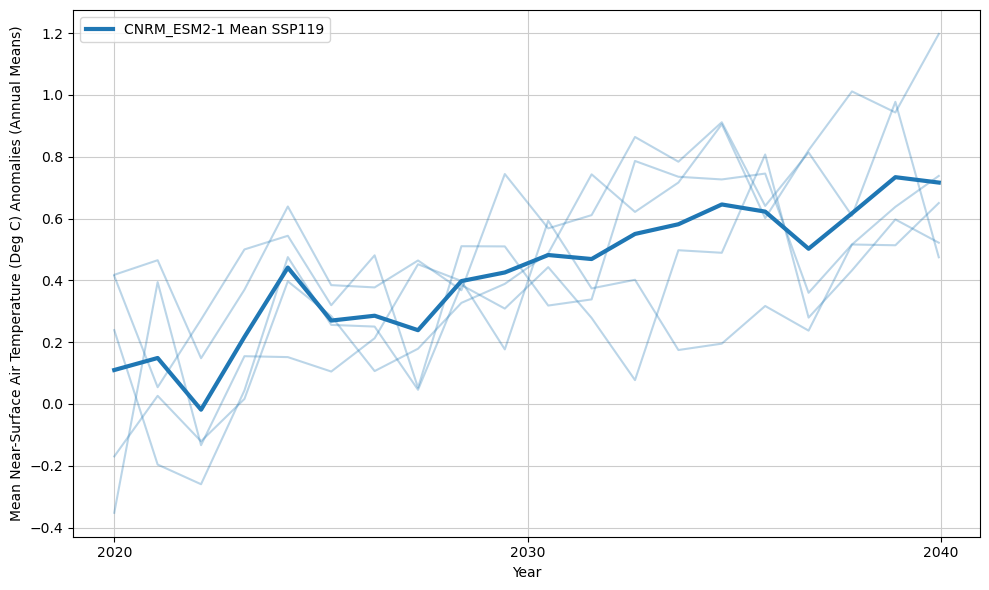

In [26]:
if __name__ == "__main__":

   # Example 1: Time-series of mean tas in ssp119 scenario for single CNRM model from 2020 to 2039
    normalized_time_series_plot(
        varname="tas",
        scenario="ssp119", 
        base_period=(2015, 2024),
        period=(2020, 2039), 
        region=None,
        stat="mean",
        multimodel=False,
        model_name = "CNRM_ESM2-1_ssp119_ssp126_201501_210012_r1-5_2pt5degree.nc",
        remove_seasonality = True
    )

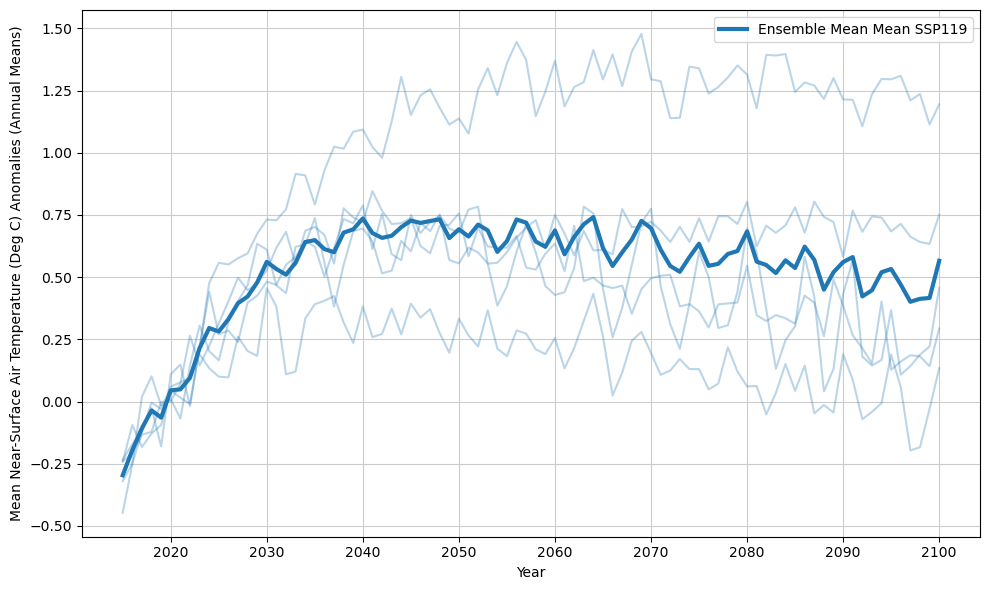

In [30]:
if __name__ == "__main__":

   # Example 2: Replicating Diffenbaugh et al. 2023 Fig 1B
    normalized_time_series_plot(
        varname="tas",
        scenario="ssp119", 
        base_period=(2015, 2024),
        period=(2015, 2100), 
        region=None,
        stat="mean",
        multimodel=True,
        model_name = None,
        remove_seasonality = True
    )

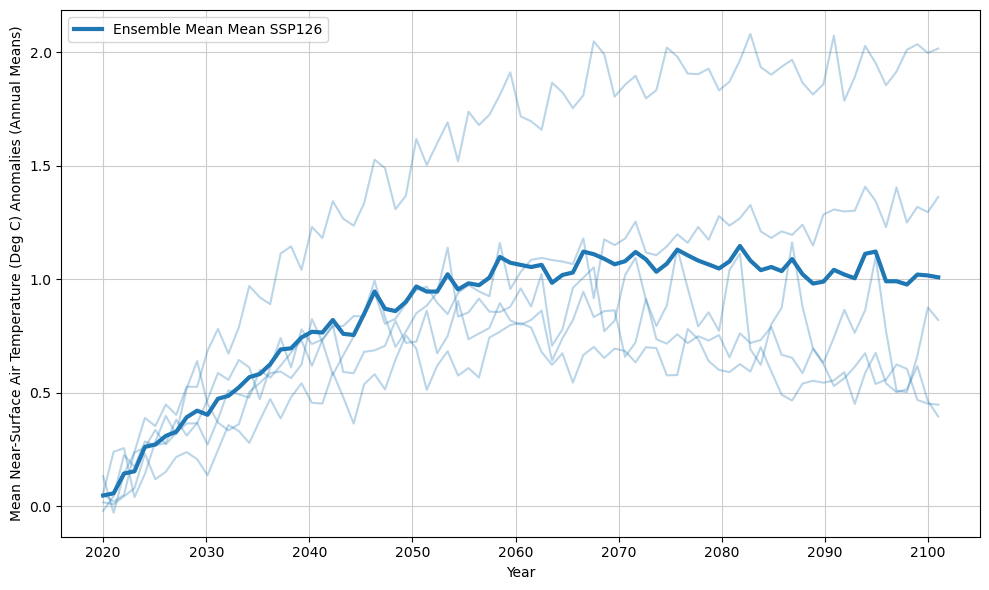

In [29]:
if __name__ == "__main__":

   # Example 2: Replicating Diffenbaugh et al. 2023 Fig 1C
    normalized_time_series_plot(
        varname="tas",
        scenario="ssp126", 
        base_period=(2015, 2024),
        period=(2015, 2100), 
        region=None,
        stat="mean",
        multimodel=True,
        model_name = None,
        remove_seasonality = True
    )